Epoch [1/100] - Train Loss: 0.7034, Train Acc: 0.5826, Val Acc: 0.6753
Epoch [2/100] - Train Loss: 0.6884, Train Acc: 0.6109, Val Acc: 0.6753
Epoch [3/100] - Train Loss: 0.6691, Train Acc: 0.6130, Val Acc: 0.6753
Epoch [4/100] - Train Loss: 0.6686, Train Acc: 0.6261, Val Acc: 0.6753
Epoch [5/100] - Train Loss: 0.6505, Train Acc: 0.6283, Val Acc: 0.6753
Epoch [6/100] - Train Loss: 0.6557, Train Acc: 0.6239, Val Acc: 0.6818
Epoch [7/100] - Train Loss: 0.6262, Train Acc: 0.6543, Val Acc: 0.6883
Epoch [8/100] - Train Loss: 0.6434, Train Acc: 0.6587, Val Acc: 0.6883
Epoch [9/100] - Train Loss: 0.6160, Train Acc: 0.6522, Val Acc: 0.6948
Epoch [10/100] - Train Loss: 0.6058, Train Acc: 0.6652, Val Acc: 0.7013
Epoch [11/100] - Train Loss: 0.6024, Train Acc: 0.6543, Val Acc: 0.6948
Epoch [12/100] - Train Loss: 0.6109, Train Acc: 0.6522, Val Acc: 0.6948
Epoch [13/100] - Train Loss: 0.6080, Train Acc: 0.6522, Val Acc: 0.7013
Epoch [14/100] - Train Loss: 0.6032, Train Acc: 0.6696, Val Acc: 0.7078
E

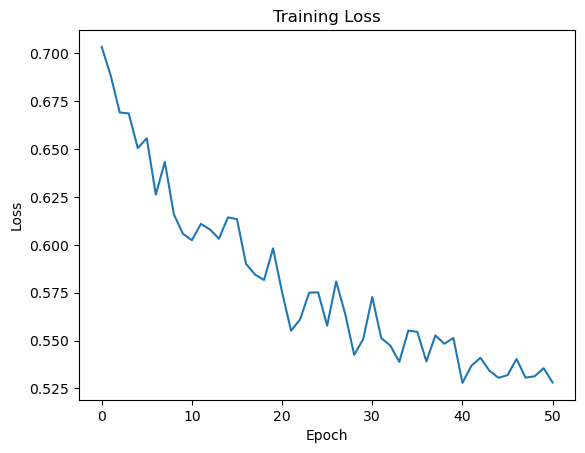

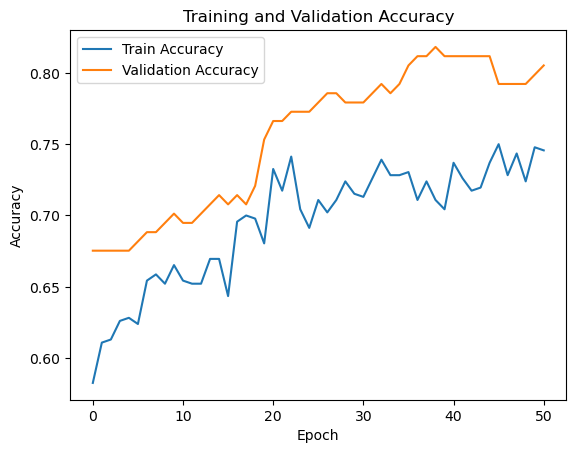

Test Accuracy: 0.7468


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
X, y = load_svmlight_file("scaled.txt")
X = pd.DataFrame(X.toarray())
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X.columns = features
y[y == -1] = 0

for column in X.columns:
    median = X[X[column] != 0][column].median()
    X[column] = X[column].replace(0, median)

# Split data training 0.6, test 0.2, validation 0.2
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train.values)
X_val = torch.FloatTensor(X_val.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)
y_test = torch.FloatTensor(y_test)

# Convert datasets to TensorDatasets
train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))  
val_dataset = TensorDataset(X_val, y_val.unsqueeze(1))
test_dataset = TensorDataset(X_test, y_test.unsqueeze(1))

batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation, dropout_prob):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            activation,
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            activation,
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_size, output_size)
        )
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.layers(x)

class L1RegularizedLoss(nn.Module):
    def __init__(self, base_loss, l1_lambda):
        super(L1RegularizedLoss, self).__init__()
        self.base_loss = base_loss
        self.l1_lambda = l1_lambda

    def forward(self, outputs, targets):
        base_loss = self.base_loss(outputs, targets)
        l1_reg = 0
        for param in self.parameters():
            l1_reg += torch.norm(param, p=1)
        total_loss = base_loss + self.l1_lambda * l1_reg
        return total_loss

input_size = 8
output_size = 1
hidden_size = 64
activation = nn.Tanh()
dropout_prob = 0.4
learning_rate = 0.0001
weight_decay = 0.001
l1_lambda = 0.01

model = MLPModel(input_size, hidden_size, output_size, activation, dropout_prob)
criterion = L1RegularizedLoss(nn.BCEWithLogitsLoss(), l1_lambda)
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

num_epochs = 100
patience = 10
best_val_loss = float('inf')
early_stopping_counter = 0
train_losses = []
val_accuracies = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    if epoch_train_loss < best_val_loss:
        best_val_loss = epoch_train_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping!")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Plot and save the Training Loss
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("training_loss.png")  
plt.show()

# Plot and save the Training and Validation Accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("training_validation_accuracy.png")  
plt.show()

model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")
